In [4]:
import pickle
import numpy as np
import sys
import logging
from tqdm.auto import tqdm
from contextlib import contextmanager

from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed

sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
sys.path.append("/home/oliver/Documents/p5control-bluefors-evaluation")

from theory.utilities.types import NDArray64
from theory.models.ha_sym import ha_sym_nonuniform_worker


@contextmanager
def suppress_logging():
    logger = logging.getLogger()
    original_level = logger.level
    logger.setLevel(logging.CRITICAL)
    try:
        yield
    finally:
        logger.setLevel(original_level)

In [5]:
# data fields
Delta_0_meV: float = 0.18
V_Delta: NDArray64 = np.concatenate(
    (
        np.arange(0, 1, 0.01),
        np.arange(1, 2, 0.02),
        np.arange(2, 2.5, 0.05),
        np.arange(2.5, 5, 0.1),
    ),
    dtype=np.float64,
)
V_mV: NDArray64 = V_Delta * Delta_0_meV

tau: NDArray64 = np.concatenate(
    (
        np.arange(0.0, 0.6, 0.05),
        np.arange(0.6, 0.9, 0.01),
        np.arange(0.9, 1.0, 0.02),
    ),
    dtype=np.float64,
)

T_K: NDArray64 = np.array([0, 0.1, 0.2, 0.3], dtype=np.float64)

Delta_Delta_0_meV: NDArray64 = np.concatenate(
    (
        np.arange(0.90, 0.95, 0.025),
        np.arange(0.95, 1.05, 0.01),
        np.arange(1.05, 1.10, 0.025),
    ),
    dtype=np.float64,
)
Delta_meV: NDArray64 = Delta_Delta_0_meV * Delta_0_meV

gamma_meV: NDArray64 = np.logspace(-4, 0, 9)

In [6]:
# generate data to compare
jobs: list[
    tuple[tuple[int, int, int, int], tuple[NDArray64, float, float, float, float, bool]]
] = []
for itau, tau_i in enumerate(tau):
    for iT, T_K_i in enumerate(T_K):
        for idel, Delta_i in enumerate(Delta_meV):
            for igam, gamma_i in enumerate(gamma_meV):
                idx = (itau, iT, idel, igam)
                args = (
                    V_mV,
                    tau_i,
                    T_K_i,
                    Delta_i,
                    gamma_i,
                    True,
                )
                jobs.append((idx, args))

n_tau = len(tau)
n_T = len(T_K)
n_Delta = len(Delta_meV)
n_gamma = len(gamma_meV)
n_V = len(V_mV)

I_nA = np.empty((n_tau, n_T, n_Delta, n_gamma, n_V))

max_workers = 8  # or 6-8 depending on your Mac / thermal tolerance :)
pbar = False

if pbar:
    p_total = tqdm(total=len(jobs), desc="(τ, T, Δ, γ)")
    p_para = tqdm(total=(n_T * n_Delta * n_gamma), desc="(T, Δ, γ)", leave=True)
    p_tau = tqdm(total=n_tau, desc="(τ)", leave=True)

with ProcessPoolExecutor(max_workers=max_workers) as ex:
    futures = {ex.submit(ha_sym_nonuniform_worker, *args): idx for idx, args in jobs}

    for fut in as_completed(futures):
        try:
            itau, iT, idel, igam = futures[fut]
            i = fut.result()
            I_nA[itau, iT, idel, igam, :] = i
        except EOFError:
            raise (fut, futures[fut])

        if pbar:
            p_total.update(1)

            p_tau.n = itau + 1
            p_tau.refresh()

            n_para = iT * n_Delta * n_gamma + idel * n_gamma + igam
            p_para.n = n_para
            p_para.refresh()

            print(itau, iT, idel, igam)
I_nA.shape

loaded constants...
loaded constants...
loaded constants...
loaded constants...
loaded constants...
loaded constants...
loaded constants...
loaded constants...


(48, 4, 16, 9, 185)

In [7]:
theo = dict(
    V_mV=V_mV,
    tau=tau,
    T_K=T_K,
    Delta_meV=Delta_meV,
    gamma_meV=gamma_meV,
    I_nA=I_nA,
)

with open("data_base_0.pickle", "wb") as f:
    pickle.dump(theo, f)

In [26]:
from typing import Optional, Dict
from pickle import load as pickle_load

import importlib

import numpy as np
from numpy.typing import NDArray

import jax.numpy as jnp

from functools import partial
from jax import device_put
from jax import vmap
from jax import jit

from jax import Array

from theory.utilities.functions import bin_y_over_x
from theory.utilities.types import NDArray64
from theory.utilities.constants import G_0_muS

from theory.utilities.functions_jax import bin_y_over_x as bin_y_over_x_jax

In [27]:
with open("data_base_0.pickle", "rb") as file:
    theo: Dict[str, NDArray64] = pickle_load(file)

In [28]:
V_theo_mV: NDArray64 = theo["V_mV"]
tau_theo: NDArray64 = theo["tau"]
T_theo_K: NDArray64 = theo["T_K"]
Delta_theo_meV: NDArray64 = theo["Delta_meV"]
gamma_theo_meV: NDArray64 = theo["gamma_meV"]
I_theo_nA: NDArray64 = theo["I_nA"]

In [29]:
V_theo_mV_jax: Array = device_put(V_theo_mV)
I_theo_nA_jax: Array = device_put(I_theo_nA)
tau_theo_jax: Array = device_put(tau_theo)
T_theo_K_jax: Array = device_put(T_theo_K)
Delta_theo_meV_jax: Array = device_put(Delta_theo_meV)
gamma_theo_meV_jax: Array = device_put(gamma_theo_meV)

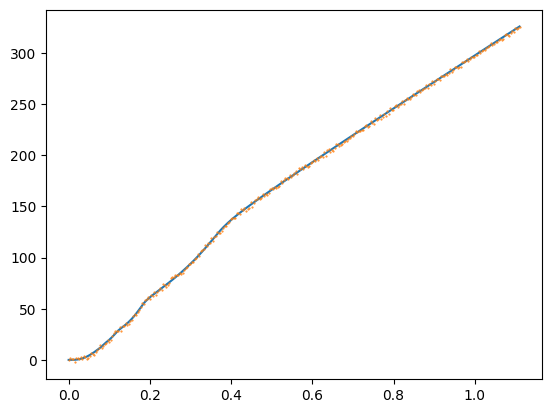

In [86]:
Delta_exp_meV: float = 0.185
V_exp_mV: NDArray64 = np.linspace(0, 6, 301, dtype=np.float64) * Delta_exp_meV
tau_exp: NDArray64 = np.array([0.8, 0.7, 0.6, 0.5, 0.4, 0.3], dtype=np.float64)
G_N_exp: float = np.sum(tau_exp)
gamma_exp_meV: float = 0.01
T_exp_K: float = 0.1

from theory.models.ha_sym import get_I_nA as get_I_nA_ha

importlib.reload(sys.modules["theory.models.ha_sym"])
import matplotlib.pyplot as plt

I_exp_nA = np.zeros_like(V_exp_mV)
for tau_i in tau_exp:
    I_exp_nA += get_I_nA_ha(
        V_mV=V_exp_mV,
        Delta_meV=Delta_exp_meV,
        tau=tau_i,
        T_K=T_exp_K,
        gamma_meV=gamma_exp_meV,
    )
I_exp_0_nA = np.copy(I_exp_nA)
I_exp_nA += (0.5 - np.random.random(len(V_exp_mV))) * 5
I_exp_nA += (0.5 - np.random.random(len(V_exp_mV))) * 1

plt.plot(V_exp_mV, I_exp_0_nA, "-", markersize=1, label="theo")
plt.plot(V_exp_mV, I_exp_nA, ".", markersize=1, label="exp")

In [87]:
def handle_G_N_exp(
    V_exp_mV: NDArray64,
    I_exp_nA: NDArray64,
    G_N_exp: Optional[float] = None,
    Delta_exp_meV: float = 0.18,
    V_threshhold_Delta: float = 2.5,
) -> float:
    G_N_0: float = 0.0
    if G_N_exp is None:
        logic: NDArray[np.bool] = V_exp_mV >= V_threshhold_Delta * Delta_exp_meV
        G_N_0: float = np.nanmean(
            np.gradient(
                I_exp_nA[logic] / G_0_muS,
                V_exp_mV[logic],
            ),
            dtype=np.float64,
        )
    else:
        G_N_0 = G_N_exp
    return G_N_0


G_N_0 = handle_G_N_exp(
    V_exp_mV=V_exp_mV,
    I_exp_nA=I_exp_nA,
    Delta_exp_meV=Delta_exp_meV,
)
G_N_0, G_N_exp

(np.float64(3.3411532876297443), np.float64(3.3))

In [ ]:
dV_theo_mV = np.nanmin(V_theo_mV[1:] - V_theo_mV[:-1])
Vmax_theo_mV = np.nanmax(V_theo_mV)

from theory.utilities.constants import V_tol_mV

V_theo_temp_mV = np.round(
    np.arange(0, Vmax_theo_mV + dV_theo_mV, dV_theo_mV),
    decimals=V_tol_mV,
)

In [ ]:
V_exp_temp_mV = bin_y_over_x(V_exp_mV, V_exp_mV, V_theo_temp_mV)
I_exp_temp_nA = bin_y_over_x(V_exp_mV, I_exp_nA, V_theo_temp_mV)

logic = np.isin(V_theo_temp_mV, V_theo_mV)

array([0.    , 0.0018, 0.0036, 0.0072, 0.009 , 0.0126, 0.0144, 0.0162,
       0.018 , 0.0234, 0.0252, 0.027 , 0.0288, 0.0324, 0.0342, 0.036 ,
       0.0378, 0.0414, 0.045 , 0.0468, 0.0504, 0.054 , 0.0576, 0.0594,
       0.063 , 0.0648, 0.0684, 0.0702, 0.072 , 0.0738, 0.0756, 0.0774,
       0.081 , 0.0828, 0.0882, 0.09  , 0.0936, 0.0954, 0.099 , 0.1008,
       0.108 , 0.1098, 0.1134, 0.1152, 0.1188, 0.1206, 0.1242, 0.126 ,
       0.1278, 0.1296, 0.1314, 0.135 , 0.1368, 0.1386, 0.1404, 0.1422,
       0.144 , 0.1458, 0.1476, 0.1494, 0.1512, 0.153 , 0.1548, 0.1566,
       0.1602, 0.162 , 0.1638, 0.1656, 0.1674, 0.171 , 0.1764, 0.1782,
       0.18  , 0.1872, 0.1908, 0.198 , 0.2016, 0.2088, 0.36  , 0.486 ,
       0.504 , 0.522 , 0.54  , 0.558 ])

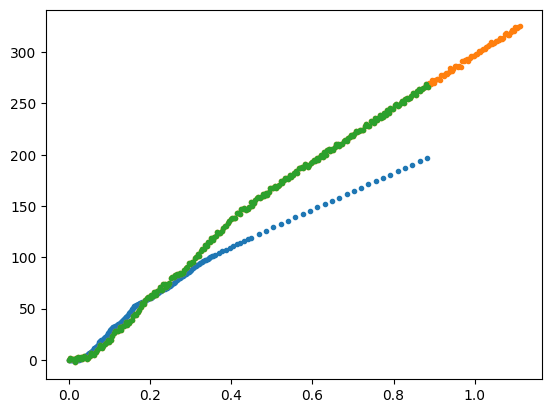

In [ ]:
plt.plot(V_theo_mV, I_theo_nA[-20, 0, 0, 0, :] * 3, ".")
plt.plot(V_exp_mV, I_exp_nA, ".")
plt.plot(V_exp_temp_mV, I_exp_temp_nA, ".")